# Gurobi优化器
* 建模流程：
![图片](image/流程.png)
* 核心概念
    * 参数：控制求解的操作，通过调用`setParam()`
            setParam('TimeLimit',60) 设置求解世界为60秒 #设置全局参数
            model.TimeLimit=60 #设置局部参数，只对这个模型有效
    * 属性：每个参数都有属性，例如：
        * 变量有名字、值、上下界等
        * 约束有名字，类型等


## 运算符介绍

### quicksum：代替python的sum，会更快
> 重点：利用列表推导式写求和式，搭配quicksum
1.  一般来说一个求和符号就代表要用一个推导式for之类，可以加入if和else限定
2. 也可以用更快速的.sum方法

例子： $\sum\limits_{j\in J}x_{i,j}\le 5\quad \forall i\in I$ 

以下两种写法是等同的：
* `m.addConstr(quicksum(x[i,j] for j in J) <= 5 for j in J)`
* `m.addConstr((x.sum(i,'*') <= 5) for i in I)`
    

## 创建模型和决策变量 
`m=grb.Model()`


### 创建单变量(可以指定上下界，具体见参数)
      grb.Model.addVar(vtype='C',name='')
        
      vtype (string): 变量类型，默认是GRB.CONTINUOUS连续型变量，
      可选择GRB.BINARY二分类变量
      GRB.INTEGER整数变量，
      GRB.SEMICONT 半连续变量，即取0或者取一个范围
      addVar(vtype=GRB.SEMICONT,lb=40,ub=100)相当于x=0或40<=x<=100
      GRB.SEMIINT 半连续整数变量同上
      name (string):变量名
      
      例如：x=m.addVar(vtype=GRB.BINARY,name='x') 


 ### 创建多变量
 
 
     addVars (*indices,vtype=,name=)
     indices：索引集
     name=常量，比如x = model.addVars(2,3,name="x")则变量会被按下标自动命名x[0,0],x[1,2]等(见线性规划第一个例子)
例如`x=m.addVars(3,vtype=GRB.CONTINUOUS)`
* 调用m.getVars()会发现gurobi创建了三个变量，分别是[<gurobi.Var C0>, <gurobi.Var C1>, <gurobi.Var C2>],通过x[0],x[1],x[2]可以分别访问到它们

例如`x=m.addVars(3,4,5,vtype=GRB>CONTINUOUS)`
* gurobi就创建了一个3x4x5的变量张量，可以通过x[i,j,k]的格式进行访问

也可以传入列表，会计算它们的笛卡尔积`m.addVars(['甲','乙'],[1,2],vtype=xx)`
* 会创建四个变量，分别为['甲',1],['甲',2],['乙',1],['乙',2]

**注意**

如果你为变量起了别名，将会导致后续循环时外部代价函数没法索引（因为不再和x[i,j,k]一样格式了），这个时候可以用dataframe，在命名好列和行名的情况下用dataframe.at[行名,列名]来取
>这种情况见整数规划中的超市经营问题有演示

In [52]:
'''返回变量'''
m=Model()
country=['美国','中国','英国','日本']
industry=['农业','工业','制造业','服务业']
x=m.addVars(country,industry)
m.update()
'''选取美国的所有产业'''
x.select('美国','*')#这其实是代表第一行，所有列

[<gurobi.Var C0>, <gurobi.Var C1>, <gurobi.Var C2>, <gurobi.Var C3>]

### tupledict
> 多变量会返回一个tupledict，具体见网站[gurobi](https://www.gurobi.com/documentation/9.5/refman/py_tuplelist.html)

**一些方法**
* select() 选取tuplelist的变量,'*'表示选取所有的那部分，其他需要指定名字或默认索引
    
    - 例如x=m.addVars(4,4),就相当于创建了一个4x4的矩阵，x.select(0,'*')为选择矩阵的第一行所有列（索引从0开始）
    - 具体见下面例子 
* sum():将select到的求和
      x = m.addVars([(1,2), (1,3), (2,3)])
      expr = x.sum()       # LinExpr: x[1,2] + x[1,3] + x[2,3]
      expr = x.sum(1, '*') # LinExpr: x[1,2] + x[1,3]
      expr = x.sum('*', 3) # LinExpr: x[1,3] + x[2,3]
      expr = x.sum(1, 3)   # LinExpr: x[1,3]

### 创建矩阵多变量
优点是直接可以用于A@x<=b，利用numpy的ndarray构造标准形式，并且可以切片

    addMVar ( shape,vtype=GRB.CONTINUOUS, name="" )
      x = model.addMVar(10)                      # add a 1-D array of 10 variables
      y = model.addMVar((3,4), vtype=GRB.BINARY) # add a 3x4 2-D array of binary variables
      print(y[:,1:3])                            # take a slice of a 2-D array

In [12]:
m=Model()
x=m.addMVar(10)
m.update()
A=np.random.randn(3,10)
b=np.random.randn(3)
con=m.addConstr(A@x<=b)
m.update()
con

<MConstr (3,)>

## 创建目标函数 `setObjective(expr, sense=None)`
* expr:表达式，如x+y或者x\*x+y\*y
* sense最优化选择，GRB.MINIMIZE最小化,GRB.MAXIMIZE最大化

In [15]:
m.setObjective(2*x1+3*x2-5*x3,GRB.MAXIMIZE)

## 创建约束条件
### 创建单约束
    m.addConstr(lhs,name='')
    lhs:约束的左侧，可以是常数、变量或线性表达式，注意只能有一个比较运算符
    name:可选的约束名
    
**例子**

* c = model.addConstr(A @ x <= b) 线性规划的标准型

* 允许添加两侧约束：$1\le x+y+z\le2$：`model.addConstr(x + y + z == [1, 2])` 
* 允许添加非线性约束：`model.addConstr(x*x + y*y <= 1)`
* 允许添加最大最小值：$z=\max(x,y)$`model.addConstr(z == min_(x, y))`
    * z==max_([x,y],constant=3) max_表示z取这些决策变量的最大值,constant里存常数

* 允许添加条件表达式：$if \quad w=1\Longrightarrow x+y\le1$`model.addConstr((w == 1) >> (x + y <= 1)) `


### 创建多个约束
**常与推导式结合使用**
* $\sum\limits_{i\in I,j\in J}x_{ijk}\ge1,\forall k \in K$,I，J，K为前面指定好的范围列表

等价于`m.addConstrs(sum(x[i,j,k] for i in I for j in J) >= 1 for k in K) `
* $\max{\sum\limits_{i\in I,j\in J,k\in K}x_{ijk}*d_{ik}*m_{jk}}$的目标函数等价于

        m.setObjective(sum(x[i, j, k] * rate_ik[i][k] * all_jk[j][k] 
        for i in I for j in J for k in K),GRB.MAXIMIZE)

## 获取各决策变量的值和最优解
1.  调用`getVars() `
 - varname获取变量名
 - x获取变量值

2. 获取最优解`m.objVal`


## 用矩阵形式存储最优解（适用非常多变量）
> 用到了获取属性值的函数 getAttr(属性,变量（可选）)，例如可以传入varname或者x
1. `solution = m.getAttr('x',x)`;`solution.items()`
* 结果类似下面
        [((0, 0), -0.0),
         ((0, 1), 19.0),
         ((0, 2), -0.0),
         ((0, 3), -0.0),
         ((0, 4), 41.0),
         ((0, 5), -0.0),
* 左边的元组为索引，右边为值，就可以写程序将其写入pandas，ndarray等
2. 直接推导式[i for i in m.getAttr('x')] 由于没有传入变量，会直接给出所有的最终值
        [5.0,
         -0.0,
         -0.0,
         10.0,
         -0.0,

## 获取求解器的更多信息
> 例如获取约束表达式等

**例如如下例子**
1. m.display()获取全部信息，需要在获取前update
1. model.getRow(con) 获取约束con的左侧表达式
1. con.Sense获取约束的符号，如大于小于等于
1. con.RHS 获取约束的右侧表达式

In [46]:
m=Model('租借')
I=(list(range(1,5)))
x=m.addVars(I,I,vtype=GRB.INTEGER,name='x') #命名为x
con=m.addConstr(quicksum(x[1,j] for j in range(1,5))>=15)
m.addConstr(x[1,2]+x[1,3]+x[1,4]+x[2,1]+x[2,2]+x[2,3]>=10)
m.addConstr(x[1,3]+x[1,4]+x[2,2]+x[2,3]+x[3,1]+x[3,2]>=20)
m.addConstr(x[1,4]+x[2,3]+x[3,2]+x[4,1]>=12)
m.setObjective(2800*sum(x.select('*',1))+4500*(x[1,2]+x[2,2]+x[3,2])+6000*(x[1,3]+x[2,3])+7300*x[1,4],GRB.MINIMIZE)
m.update()
m.display()

Minimize
2800.0 x[1,1] + 4500.0 x[1,2] + 6000.0 x[1,3] + 7300.0 x[1,4] + 2800.0 x[2,1]
+ 4500.0 x[2,2] + 6000.0 x[2,3] + 2800.0 x[3,1] + 4500.0 x[3,2] + 2800.0 x[4,1]
Subject To
  R0: x[1,1] + x[1,2] + x[1,3] + x[1,4] >= 15
  R1: x[1,2] + x[1,3] + x[1,4] + x[2,1] + x[2,2] + x[2,3] >= 10
  R2: x[1,3] + x[1,4] + x[2,2] + x[2,3] + x[3,1] + x[3,2] >= 20
  R3: x[1,4] + x[2,3] + x[3,2] + x[4,1] >= 12
General Integers
['x[1,1]', 'x[1,2]', 'x[1,3]', 'x[1,4]', 'x[2,1]', 'x[2,2]', 'x[2,3]', 'x[2,4]',
 'x[3,1]', 'x[3,2]', 'x[3,3]', 'x[3,4]', 'x[4,1]', 'x[4,2]', 'x[4,3]', 'x[4,4]']


# 线性规划

## 例题一
见python建模书投资题
* 可以改成矩阵形式

In [43]:
m=Model('租借')
I=(list(range(1,5)))
x=m.addVars(I,I,vtype=GRB.INTEGER,name='x') #命名为x
m.update()
con=m.addConstr(quicksum(x[1,j] for j in range(1,5))>=15)
m.addConstr(x[1,2]+x[1,3]+x[1,4]+x[2,1]+x[2,2]+x[2,3]>=10)
m.addConstr(x[1,3]+x[1,4]+x[2,2]+x[2,3]+x[3,1]+x[3,2]>=20)
m.addConstr(x[1,4]+x[2,3]+x[3,2]+x[4,1]>=12)
m.setObjective(2800*sum(x.select('*',1))+4500*(x[1,2]+x[2,2]+x[3,2])+6000*(x[1,3]+x[2,3])+7300*x[1,4],GRB.MINIMIZE)
m.setParam('OutputFlag', 0) #关闭求解信息
m.optimize()
for i in m.getVars():
    print(f'{i.varname}的最优解为：{i.x}')
print('最优解为：',m.objVal)

x[1,1]的最优解为：5.0
x[1,2]的最优解为：-0.0
x[1,3]的最优解为：-0.0
x[1,4]的最优解为：10.0
x[2,1]的最优解为：-0.0
x[2,2]的最优解为：-0.0
x[2,3]的最优解为：-0.0
x[2,4]的最优解为：-0.0
x[3,1]的最优解为：8.0
x[3,2]的最优解为：2.0
x[3,3]的最优解为：-0.0
x[3,4]的最优解为：-0.0
x[4,1]的最优解为：-0.0
x[4,2]的最优解为：-0.0
x[4,3]的最优解为：-0.0
x[4,4]的最优解为：-0.0
最优解为： 118400.0


## 例题2
见姜启源书第一题

In [24]:
from gurobipy import *
import numpy as np
m=Model()
x=m.addMVar(2,vtype=GRB.INTEGER,name='x')
m.update()
A=np.array([[12,8],[1,1],[3,0]])
b=np.array([480,50,100])
m.addConstr(A@x<=b)
m.setObjective(72*x[0]+64*x[1],GRB.MAXIMIZE)
m.setParam('OutputFlag', 0) #关闭求解信息
m.optimize()
for i in m.getVars():
    print(f'{i.varname}的最优解为：{i.x}')
print('最优解为：',m.objVal)

x[0]的最优解为：20.0
x[1]的最优解为：30.0
最优解为： 3360.0


## 例题3 运输问题
* 重点学习我quicksum里面的写法
* 这里将注意如何输入输出格式

In [45]:
from gurobipy import *
import numpy as np
import pandas as pd
path=r"D:\jupyter\大数据建模\Python数学建模算法与应用程序和数据\04第4章  线性规划和整数规划模型\data4_5_1.txt"
N=pd.read_table(path,header=None).rename(index=lambda x:'A'+str(x+1),columns=lambda x:'B'+str(x+1))
N.rename(columns={'B9':'产量'},index={'A7':'销量'},inplace=True)
d=N.iloc[-1,:-1].values
e=N.iloc[:-1,-1].values.astype(np.int32)
C=N.iloc[:-1,:-1].values
N

,B1,B2,B3,B4,B5,B6,B7,B8,产量
A1,6,2,6,7,4,2,5,9,60
A2,4,9,5,3,8,5,8,2,55
A3,5,2,1,9,7,4,3,3,51
A4,7,6,7,3,9,2,7,1,43
A5,2,3,9,5,7,2,6,5,41
A6,5,5,2,2,8,1,4,3,52
销量,35,37,22,32,41,32,43,38,


In [51]:
m=Model('运输')
x=m.addVars(6,8,vtype=GRB.INTEGER,name='x')
m.update()
m.setObjective(quicksum(C[i][j]*x[i,j] for i in range(6) for j in range(8)),GRB.MINIMIZE)
m.addConstrs(quicksum(x[i,j] for i in range(6) )==d[j] for j in range(8))
m.addConstrs(quicksum(x[i,j] for j in range(8))<=e[i] for i in range(6))
m.setParam('OutputFlag', 0) #关闭求解信息
m.optimize()
def print_result(m):
    solution = m.getAttr('x',x)
    solution_matrix=np.zeros((6,8))
    for i,j in solution.items():
        solution_matrix[i[0]][i[1]]=j
    print(f'最优解为：{m.ObjVal}')
    return solution_matrix
print_result(m)

最优解为：664.0


array([[-0., 19., -0., -0., 41., -0., -0., -0.],
       [ 1., -0., -0., 32., -0., -0., -0., -0.],
       [-0., 11.,  0., -0., -0., -0., 40., -0.],
       [-0., -0., -0., -0., -0.,  5., -0., 38.],
       [34.,  7., -0., -0., -0., -0., -0., -0.],
       [-0., -0., 22.,  0., -0., 27.,  3., -0.]])

# 整数规划
>当决策变量一个或多个是整数就是整数规划，特别的有0-1整数规划，即决策变量只能取0或1

个人理解：$\sum\limits_{i=1}^nx_{ij}=1 \quad \forall j\in J $
* 求和符号表示<span class="burk">对所有</span>，比如一个地方只能去一次，就是对所有人去这个地方的决策变量和为1
* 任意符号或者在外面的$j=1,2,\cdots,n$表示<span class="burk">对每个</span>,即相当于外层的循环

## TSP问题
TSP的目标是找到一条从某个起点出发，一次不重复地经过所有其他节点，最终返回起点的最短路。
1. 决策变量 $x_{ij}=\begin{cases}1\quad推销员决定从i地前往j地\\0\quad推销员不从i地去j地\end{cases}$
2. 目标函数：最小化旅行费用$\min\sum\limits_{i=1}^n\sum\limits_{j=1}^nc_{ij}x_{ij}$ 即从所有可能i到所有可能j地的路径费用是最短的
**约束**

1. 每个城市进入和出去只能为一次（一次走完的意思，不允许回头路）
    * $\sum\limits_{i=1}^nx_{ij}=1 \quad\forall j\in N$ 从所有可能来源地到目的地最多一次
    *  $\sum\limits_{j=1}^nx_{ij}=1 \quad\forall i\in N$ 从该地选择去的地方最多一个 
2. 破圈约束：$u_i-u_{j}+n*x_{ij}\le n-1\quad i,j=2,3\cdots n且u[1]=0$
    * 这意味着循环时可以从1而不是0开始，u[0]会自动变为0

In [6]:
from gurobipy import *
import numpy as np
import pandas as pd

mat=pd.read_excel(r"D:\jupyter\大数据建模\期末\A机器人时间矩阵.xlsx",index_col=0)

def tsp(matrix):
    n=len(matrix)
    N=range(n)
    m = Model('tsp')
    # 变量设置
    x = m.addVars(n, n, vtype=GRB.BINARY, name='x')
    u = m.addVars(n, vtype=GRB.CONTINUOUS, name='u')

    # 目标函数
    m.setObjective(quicksum(matrix[i,j] * x[i, j] for i in N for j in N), GRB.MINIMIZE)

    # 添加限制
    m.addConstrs(quicksum(x[i, j] for i in N ) == 1 for j in N)
    m.addConstrs(quicksum(x[i, j] for j in N) == 1 for i in N)
    m.addConstrs(
        (u[i] - u[j] + n * x[i, j]) <=  n- 1 for i in range(1,n) for j in range(1, n) )

    m.setParam('OutputFlag', 0) #关闭求解信息 

    m.optimize()

    print('最优解：',m.ObjVal)

    # 找到那些是1的变量
    result = []
    for i in range(n):
        for j in range(n):
            if x[i, j].X == 1:
                result.append([i,j])
    return result
def tsp_to_cycle(tsp_solution):
    # tsp_solution是一个list,每个元素也是一个list,表示一条路径
    cycle = []
    visited = set()

    # 找第一个未访问的点
    for path in tsp_solution:
        if path[0] not in visited:
            cycle.append(path[0])
            visited.add(path[0])
            break 

    # 从第一个点开始扩展路径        
    curr = path[0]
    while len(visited) < len(tsp_solution):
        for path in tsp_solution:
            if path[0] == curr and path[1] not in visited:
                cycle.append(path[1])
                visited.add(path[1])
                curr = path[1]
                break

    # 最后再连回起点
    cycle.append(cycle[0])  

    return cycle
result=tsp(mat.values)
print(tsp_to_cycle(result))

最优解： 3.0375
[0, 6, 7, 8, 14, 13, 12, 18, 19, 20, 26, 25, 24, 30, 31, 32, 33, 27, 21, 15, 9, 10, 16, 22, 28, 34, 35, 29, 23, 17, 11, 5, 4, 3, 2, 1, 0]


## 工人安排问题

In [1]:
from gurobipy import *
import numpy as np
def print_result(m):
    for i in m.getVars():
        print(f'{i.varname}的最优解为：{i.x}')
    print('最优解为：',m.objVal)
m=Model()
x=m.addVars(6,vtype=GRB.INTEGER)
m.update()
m.addConstr(x[0]+x[5]>=35)
for i,j in enumerate([40,50,45,55,30]):
    m.addConstr(x[i]+x[i+1]>=j)
m.setObjective(quicksum(x[i] for i in range(6)),GRB.MINIMIZE)
m.setParam('OutputFlag', 0) #关闭求解信息
m.optimize()
print_result(m)

C0的最优解为：0.0
C1的最优解为：40.0
C2的最优解为：10.0
C3的最优解为：35.0
C4的最优解为：20.0
C5的最优解为：35.0
最优解为： 140.0


## 超市经营问题
![](image/super.jpg)
**模型建立**
>即我们要为五个门店各自选一个装修公司，并且让总费用最小

1. 定义0-1变量$x_{ij}$当第i个装修公司对第j个门店进行装修时就取1
2. 定义$c_{ij}$即代价矩阵的元素，为第i个公司对第j门店装修时的价格
3. 目标函数：对所有（可能的）装修公司装修的所有门店的总价格最小 $\min\sum\limits_{i=1}^4\sum\limits_{j=1}^6c_{ij}x_{ij}$
4. 约束条件：
    - 每个门店只能有一个公司装修$\sum\limits_{i=1}^4x_{ij}=1\quad \forall j \in J$
    - 每个公司最多承担两个门店任务 $\sum\limits_{j=1}^6x_{ij}\le2\quad \forall i \in I$

In [61]:
from gurobipy import *
import numpy as np
import pandas as pd
'''数据准备'''

I=list('ABCD') #公司集
J=[f'门店{i}' for i in range(1,6)] #门店集合
C=pd.read_table(r"D:\jupyter\大数据建模\Python数学建模算法与应用程序和数据\04第4章  线性规划和整数规划模型\data4_10.txt",
                header=None,names=J)
C.index=I
C


,门店1,门店2,门店3,门店4,门店5
A,15.0,13.8,12.5,11.0,14.3
B,14.5,14.0,13.2,10.5,15.0
C,13.8,13.0,12.8,11.3,14.6
D,14.7,13.6,13.0,11.6,14.0


In [64]:
m = Model()
x = m.addVars(I, J, vtype=GRB.BINARY)
m.update()
m.setObjective(quicksum(C.at[i,j] * x[i,j] for i in I for j in J), GRB.MINIMIZE)
m.addConstrs(quicksum(x[i,j] for i in I)==1 for j in J)
m.addConstrs(quicksum(x[i,j] for j in J)<=2 for i in I)
m.setParam('OutputFlag', 0) #关闭求解信息
m.optimize()
R=C.copy()
for i,j in m.getAttr('x',x).items():
    if j==0:
        R.at[i[0],i[1]]=j
R#最终答案为63.8

,门店1,门店2,门店3,门店4,门店5
A,0.0,0.0,12.5,0.0,0.0
B,0.0,0.0,0.0,10.5,0.0
C,13.8,13.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,14.0


## 投资风险与收益

### 模型一：固定风险水平，最大化收益
1. $\max\sum\limits_{i=0}^n(r_i-p_i)x_i$
1. 最大损失率约束：a为给定的水平$\dfrac{q_ix_i}{M}\le a$
3. 拥有资金约束：$\sum\limits_{i=0}^n(1+p_i)x_i=M$
4. 非负投资额约束：$x_i\ge 0$

In [31]:
import numpy as np

from gurobipy import *
import plotly.graph_objects as go

R_P = np.array([0.05, 0.27, 0.19, 0.185, 0.185])  #利率减去费率
C = np.array([1, 1.01, 1.02, 1.045, 1.065])  #购买资产费用
M = 10000
Q = np.array([0, 0.025, 0.015, 0.055, 0.026])  #最大损失率约束
a = 0
aa = []
result = []
while a <= 0.05:
    a += 0.001
    m = Model()
    x = m.addMVar(5, name='x')
    m.update()
    m.setObjective(R_P @ x, GRB.MAXIMIZE)
    m.addConstr(C @ x == M) #即线性求和的约束
    m.addConstrs(x[i] * Q[i] <= a * M for i in range(1, len(Q))) #没有包含为0的约束
    m.setParam('OutputFlag', 0)  #关闭求解信息
    try:
        m.optimize()
    except:
        marker = dict(symbol='star', size=12)
    result.append(m.ObjVal)
    aa.append(a)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=aa,
               y=result,
               marker=dict(symbol='star', size=12),
               mode='markers'))

fig.update_layout(title_text='风险收益图', xaxis_title_text='风险值')
fig.update_layout(font=dict(size=18, ))
fig

## 比赛项目排序问题
已知：40名运动员对14个项目的报名情况，给出项目排序方案，尽可能<span class="girk">不让运动员连续参加两场比赛</span>

**思路**
1. 抽象编码：参考onehot编码，运动员参加比赛可视为1，不参加视为0，给出40x14的报名矩阵
2. 目标肯定是最小化连续参加两场比赛的运动员数，下一步目标就是找出变量衡量这个数字
3. 连续参加两场比赛，就是两场比赛都有参加的运动员，即同时参加两个比赛的人数
4. 每个比赛都可以衡量和另一个比赛的共同人数，可以考虑构造完全无向赋权图，权数就是两个比赛的共同参加人数
5. 目标是求一个安排，即遍历所有项目，最终转化为TSP问题

In [2]:
import pandas as pd
import numpy as np
from gurobipy import *

data = pd.read_excel(
    r"D:\jupyter\大数据建模\Python数学建模算法与应用程序和数据\04第4章  线性规划和整数规划模型\data4_13_1.xlsx",
    header=None)
data.fillna(0, inplace=True)  #缺失值替换为0
A = data.values
m, n = A.shape  #获得行数和列数


def get_weight_matrix():
    weight_martix = np.zeros((n + 1, n + 1))  #创建15x15的邻接矩阵，引入虚拟变量第15项目
    for i in range(n):  #获取同时参加两项目的人数
        for j in range(n):
            if i != j:
                weight_martix[i, j] = sum(A[:, i] * A[:, j])
    return weight_martix
weight_martix=get_weight_matrix()
'''已经拿到了邻接矩阵，可以开始TSP问题求解'''
def tsp(matrix):
    n=len(matrix)
    N=range(n)
    m = Model('tsp')
    # 变量设置
    x = m.addVars(n, n, vtype=GRB.BINARY, name='x')
    u = m.addVars(n, vtype=GRB.CONTINUOUS, name='u')

    # 目标函数
    m.setObjective(quicksum(matrix[i,j] * x[i, j] for i in N for j in N if i!=j), GRB.MINIMIZE)

    # 添加限制
    m.addConstrs(quicksum(x[i, j] for i in N ) == 1 for j in N)
    m.addConstrs(quicksum(x[i, j] for j in N) == 1 for i in N)
    m.addConstrs(
        (u[i] - u[j] + n * x[i, j]) <=  n- 1 for i in range(1,n) for j in range(1, n) )

    m.setParam('OutputFlag', 0) #关闭求解信息 
    m.optimize()

    print(m.ObjVal)

    # 找到那些是1的变量
    result = []
    for i in range(n):
        for j in range(n):
            if x[i, j].X == 1:
                result.append([f'项目{i+1}', f'项目{j+1}'])
    print(result)
tsp(weight_martix)

2.0
[['项目1', '项目5'], ['项目2', '项目14'], ['项目3', '项目6'], ['项目4', '项目8'], ['项目5', '项目7'], ['项目6', '项目2'], ['项目7', '项目11'], ['项目8', '项目1'], ['项目9', '项目4'], ['项目10', '项目13'], ['项目11', '项目3'], ['项目12', '项目10'], ['项目13', '项目15'], ['项目14', '项目12'], ['项目15', '项目9']]


# VRP问题

## CVRP问题：容量限制的VRP问题
**符号说明**
* n客户点数量
* N客户点集合（不包括depot）
* V顶点集，包括客户和depot
* A:边集
* $c_{ij}$从i到j地的费用
* Q：车辆的容量限制
* $q_i$客户i的书本需求

**目标函数**
$\sum\limits_{i,j\in V}c_{ij}x{_{ij}}$最小化耗费（可以是时间或距离）
<br>**约束**
<br>1. 非depot的客户点出流为一次，即只能从这里去往别处一次：<br>$\sum\limits_{j\in V,i\not = j}x_{ij}=1\quad\forall i\in N$ 
<br>2. 非depot的客户点入流为一次，即只能到访这里一次：<br>$\sum\limits_{i\in V,i\not = j}x_{ij}=1\quad\forall j\in N$ 
<br>3.载流约束，只有从i到j点，才能拿上j点的货物并更新当前载重
<br>$if\quad x_{ij}=1\Longrightarrow u_i+q_j=u_j\quad i,j\in A,i,j\not=0$
<br>载重约束：在i处的载重必须小于限重，大于在i处的需求（因为到了i地必定拿上了i地的货物）
<br>4. $q_i\le u_i\le Q\quad i\in N$

1150.164180577383


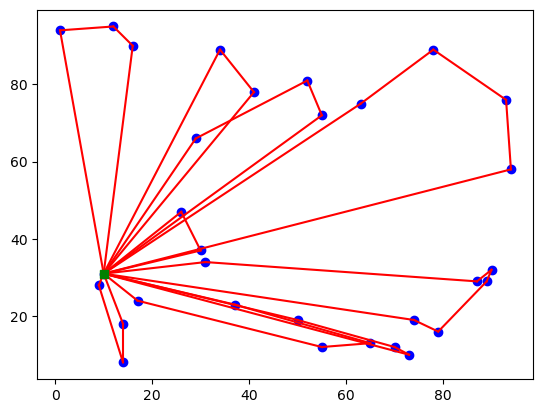

In [6]:
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt
#创建虚拟,0为depot
def cvrp(n):
    n=n #客户数量
    np.random.seed(10)
    xc=np.random.randint(1,100,n+1) #创建depot和客户的坐标，depot索引为0
    yc=np.random.randint(1,100,n+1)
    N=list(range(1,n+1))
    V=list(range(0,n+1))
    A=[(i,j) for i in V for j in V if i!=j] #创建所有相连边集合（可以对应上距离）
    C={(i,j):np.hypot(xc[i]-xc[j],yc[i]-yc[j]) for i,j in A}#从i到j的耗费
    Q=10 #车载重限制
    q={i:np.random.randint(1,6) for i in N} #为客户生成随机需求
    m=Model('CVRP')
    x=m.addVars(A,vtype=GRB.BINARY,name='x')
    u=m.addVars(N,vtype=GRB.CONTINUOUS,name='u')
    m.setObjective(quicksum(x[i,j]*C[i,j] for i,j in A),GRB.MINIMIZE)
    #注意这里python的多维字典，元组作为键时是支持C[i,j]这样来访问值的，相当于C[(i,j)]
    m.addConstrs(quicksum(x[i,j] for i in V if i!=j)==1 for j in N )
    m.addConstrs(quicksum(x[i,j] for j in V if i!=j)==1 for i in N)
    m.addConstrs((x[i,j]==1)>>((u[i]+q[j])==u[j]) for i,j in A if j!=0 and i!=0)#条件式约束，具体见上面介绍单约束部分
    m.addConstrs(q[i]<=u[i] for i in N)
    m.addConstrs(u[i]<=Q for i in N)
    m.update()
    #求解模型

    m.setParam('OutputFlag', 0) #关闭求解信息 
    m.setParam('TimeLimit',30)
    m.optimize()
    print(m.ObjVal)
    arcs=[i for i in A if x[i].x>0.9] #不要==1，因为会因为计算机问题导致0.99999等
    for index,[i,j] in enumerate(arcs):
        plt.plot([xc[i],xc[j]],[yc[i],yc[j]],c='r')
    plt.plot(xc[0],yc[0],c='g',marker='s')
    plt.scatter(xc,yc,c='b')
    plt.show()


In [26]:
n=10 #客户数量
np.random.seed(10)
xc=np.random.randint(1,100,n+1) #创建depot和客户的坐标，depot索引为0
yc=np.random.randint(1,100,n+1)
N=list(range(1,n+1))
V=list(range(0,n+1))
A=[(i,j) for i in V for j in V if i!=j] #创建所有相连边集合（可以对应上距离）
C={(i,j):np.hypot(xc[i]-xc[j],yc[i]-yc[j]) for i,j in A}#从i到j的耗费
Q=10 #车载重限制
q={i:np.random.randint(1,6) for i in N} #为客户生成随机需求
m=Model('CVRP')
x1=m.addVars(A,vtype=GRB.BINARY,name='x1')
x2=m.addVars(A,vtype=GRB.BINARY,name='x2')
u=m.addVars(N,vtype=GRB.CONTINUOUS,name='u')

m.update()

# 期末作业

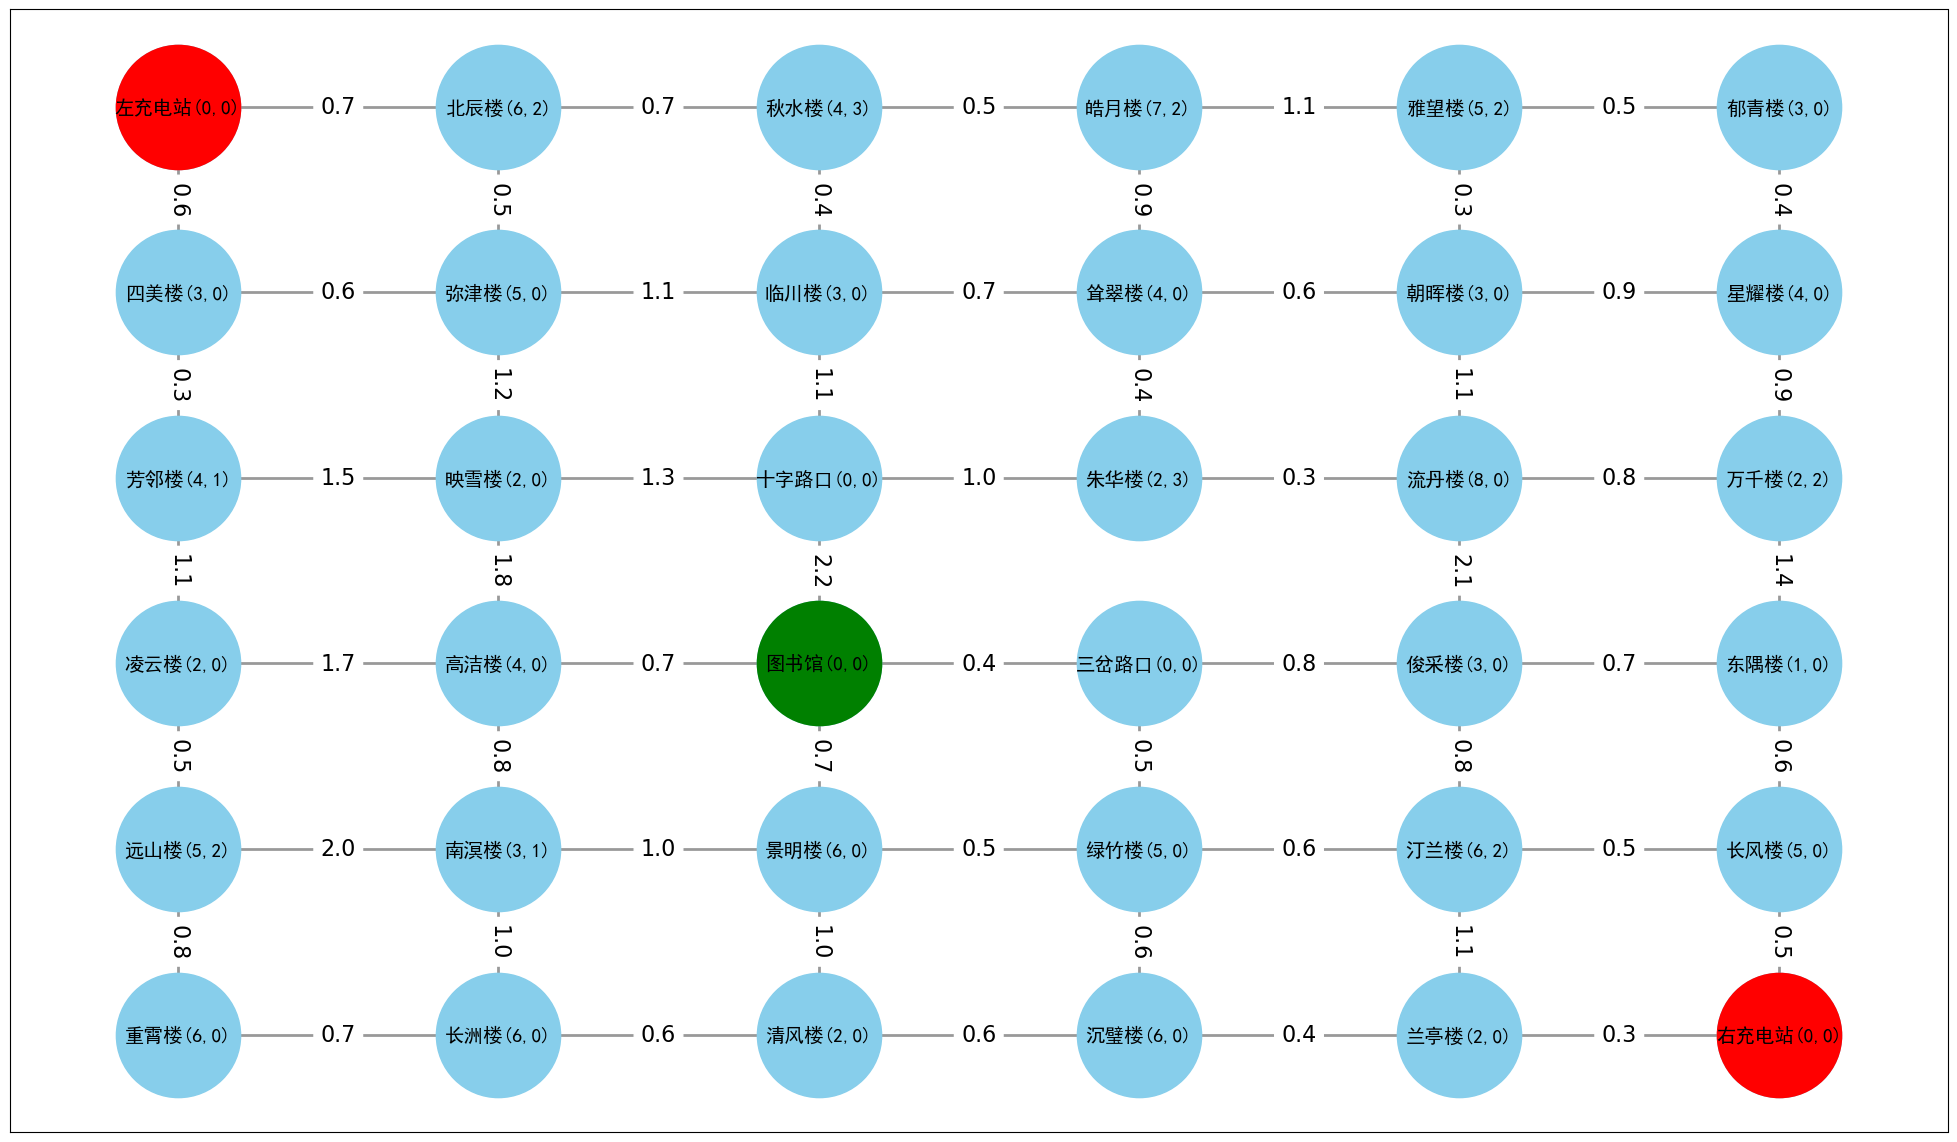

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import ctypes

import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# Implement the default Matplotlib key bindings.




'''数据读取'''

'''读取书本数据'''
books=pd.read_excel('楼宇信息.xlsx',index_col=0,header=0)
'''读取矩阵数据'''
adj=pd.read_excel('adjacent.xlsx',header=0,index_col=0)
distance=pd.read_excel('distance_matrix.xlsx',header=0,index_col=0)




def modify_graph():
    '''返回设定好的图,请传入dataframe'''
    #转换为numpy
    adj_matrix=adj.to_numpy()
    #adj[np.where(adj == INF)] = 0

    # 创建无向赋权图对象
    G = nx.Graph()

    # 添加节点
    for index in adj.index:
        G.add_node(index,name=index,back=books.loc[index][0],borrow=books.loc[index][1],state='idle') #默认每个点是空闲的

    # 添加边
    rows, cols = np.where(adj > 0)  #返回满足条件的行和列数组索引位置
    for i in range(len(rows)): #转化成对应的楼宇名称
        G.add_edge(adj.index[rows[i]], adj.index[cols[i]], 
                   weight=adj_matrix[rows[i], cols[i]])#指明连接哪两个节点和边权,注意传入的是索引，索引指向对应的行列标签
    return G
G=modify_graph()

'''画图工具,传入图对象'''
def get_node_pos(adj):
    locations = {}
    x = 0 
    y = 5
    for i in adj.index:
        locations[i] = (x,y)
        if y > 0:
            y -= 1
        else:
            x += 1
            y = 5
    return locations

# 绘制无向赋权图部分
#创建matplotlib子图承载图
fig = plt.figure(figsize=(25,25))
#设置坐标位置

pos_node=get_node_pos(adj)
#设置画图项
nx.draw_networkx_nodes(G, pos=pos_node, node_size=8000, node_color='skyblue')
nx.draw_networkx_nodes(G,nodelist=['左充电站','右充电站'],pos={'左充电站':(0,5),'右充电站':(5,0)}, node_size=8000, node_color='red')
nx.draw_networkx_nodes(G,nodelist=['图书馆'],pos={'图书馆':(2,2)}, node_size=8000, node_color='green')

nx.draw_networkx_edges(G, pos=pos_node, edge_color='gray', alpha=0.8,width=2)
#获取边的属性，设置给label作为显示在边上的权
labels_edge = nx.get_edge_attributes(G, 'weight')
#边的label
nx.draw_networkx_edge_labels(G, pos_node, edge_labels=labels_edge, font_size=16)
#画结点的label
labels_node={i:f'{i}({G._node[i]["back"]},{G._node[i]["borrow"]})' for i in adj.index }
nx.draw_networkx_labels(G, pos_node, font_size=14, font_family='SimHei',labels=labels_node)


def test():
    try:
        nx.draw_networkx_nodes(G,nodelist=['图书馆'],pos={'图书馆':(2,2)}, node_size=8000, node_color=etn.get())
        canvas.draw()
    except:
        pass


# 绘制图形

# 创建GUI
root = tk.Tk()
var1=0
ctypes.windll.shcore.SetProcessDpiAwareness(1) #解决缩放问题
button_quit = tk.Button(master=root, text="Quit", command=root.destroy)
button_quit.pack(side=tk.TOP)
canvas = FigureCanvasTkAgg(fig, root)  
canvas.draw() #更新画布 此后都要更新画布
btn=tk.Button(root,text='kick',command=test)
btn.pack()
etn=tk.Entry(root,textvariable=var1)
etn.pack()
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)


root.mainloop()




### 第一问

In [210]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
'''数据读取'''

'''读取书本数据'''
books=pd.read_excel('楼宇信息.xlsx',index_col=0,header=0)
'''读取矩阵数据'''
adj=pd.read_excel('adjacent.xlsx',header=0,index_col=0)
distance=pd.read_excel('distance_matrix.xlsx',header=0,index_col=0)




def modify_graph():
    '''返回设定好的图,请传入dataframe'''
    #转换为numpy
    adj_matrix=adj.to_numpy()
    #adj[np.where(adj == INF)] = 0

    # 创建无向赋权图对象
    G = nx.Graph()

    # 添加节点
    for index in adj.index:
        G.add_node(index,name=index,back=books.loc[index][0],borrow=books.loc[index][1],state='idle') #默认每个点是空闲的

    # 添加边
    rows, cols = np.where(adj > 0)  #返回满足条件的行和列数组索引位置
    for i in range(len(rows)): #转化成对应的楼宇名称
        G.add_edge(adj.index[rows[i]], adj.index[cols[i]], 
                   weight=adj_matrix[rows[i], cols[i]])#指明连接哪两个节点和边权,注意传入的是索引，索引指向对应的行列标签
    return G

def graph_draw(G):
    '''画图工具,传入图对象'''
    def get_node_pos(adj):
        locations = {}
        x = 0 
        y = 5
        for i in adj.index:
            locations[i] = (x,y)
            if y > 0:
                y -= 1
            else:
                x += 1
                y = 5
        return locations
    
    # 绘制无向赋权图部分
    #创建matplotlib子图承载图
    plt.figure(figsize=(25,25))
    plt.subplot(111)
    #设置坐标位置
    
    pos_node=get_node_pos(adj)
    #设置画图项
    nx.draw_networkx_nodes(G, pos=pos_node, node_size=10000, node_color='skyblue')
    nx.draw_networkx_nodes(G,nodelist=['左充电站','右充电站'],pos={'左充电站':(0,5),'右充电站':(5,0)}, node_size=10000, node_color='red')
    nx.draw_networkx_nodes(G,nodelist=['图书馆'],pos={'图书馆':(2,2)}, node_size=10000, node_color='green')
    
    nx.draw_networkx_edges(G, pos=pos_node, edge_color='gray', alpha=0.8,width=2)
    #获取边的属性，设置给label作为显示在边上的权
    labels_edge = nx.get_edge_attributes(G, 'weight')
    #边的label
    nx.draw_networkx_edge_labels(G, pos_node, edge_labels=labels_edge, font_size=19)
    #画结点的label
    labels_node={i:f'{i}({G._node[i]["back"]},{G._node[i]["borrow"]})' for i in adj.index }
    nx.draw_networkx_labels(G, pos_node, font_size=14, font_family='SimHei',labels=labels_node)
    plt.axis('off')

    #绘制给定的最短路图
    plt.show()

def get_cost_matrix():
    G=modify_graph()
    pd.DataFrame(nx.floyd_warshall_numpy(G)).to_excel('distance_matrix.xlsx')
class Robot:
    def __init__(self,velocity:int,capacity:int,name:str,base:str,constraint=12) -> None:
        self.name=name#机器人编号
        self.velocity=velocity #机器人速度
        self.capacity=capacity #机器人容量
        self.mode='start' #机器人当前模式 有三种，出发start（充电站去图书馆）,working,decision决策等待,返回retrieve（返回充电站）,complete完成工作
        self.location=base #机器人当前位置
        self.base=base #机器人驻地
        self.time_remain=0 #到达下个节点前的时间
        self.load=0 #机器人当前负载
        self.mintime=distance/self.velocity #机器人已知的每个点到每个点的最短用时
        self.mission_queue=[] #任务队列
        self.timer=0 #计时器
        self.constraint=constraint #步数限制，防止能力过低的机器人跑太远 (似乎一点用都没有)
        self.run() #初始化
        
    def get_mintime(self,u,v):
        '''获取起点u到终点v的最短时间'''
        return self.mintime.at[u,v]
    
    def calculator(self,route:list):
        '''计算一条路径上的流,时间
        流的计算为：流出+流入（收到还书是流入，发放是流出）
        example:['右充电站', '兰亭楼', '沉璧楼']
        '''
        load=self.load #一个虚拟的load，用来决策
        flow_per_path=[0] #第一个地点没有流
        time=0 #计算这段路的时间
        for index,building in enumerate(route):
            if index==0: #跳过第一个地点，因为决策处只发生在图书馆或充电站
                continue
            if load+map.get_building_back(building)>self.capacity and load!=self.capacity:
                #超重但没有满载，例如当前负重9，该地还书需求3，则只能带走1
                flow_per_path.append(self.capacity-load)
              
                
                time+=self.get_mintime(route[index-1],route[index])
                
                # print(f'机器人{self.name}在地点{building}因超过载重上限，仅拿取了{self.capacity-load}的货物')
                load=self.capacity
                continue
            if load==self.capacity: #满载的情况，没有流
                flow_per_path.append(0)
                time+=self.get_mintime(route[index-1],route[index])
                continue
            flow_per_path.append(map.get_building_back(building))
            load+=map.get_building_back(building)
            time+=self.get_mintime(route[index-1],route[index])
            # print(f'机器人{self.name}在地点{building}成功拿取货物{map.get_building_back(building)}')
        

        return sum(flow_per_path),time,flow_per_path
        

    
    def route_chooser(self,start,end):
        '''根据当前地点,利用拓展树返回一条最优路径队列'''
        index=1
        best=[0,1000]
        bestroute=[]
        
        while True:
        
            all_route=[i for i in list(nx.all_simple_paths(map.G,start,end,cutoff=index)) if len(i)==index+1] #走n步会有n+1个节点
            if not all_route: #如果路是空的
                index+=1
                continue
            for i in all_route:
                current=self.calculator(i) #记录当前路径得分
                if current[0]>best[0]:
                    best=current
                    bestroute=i
                elif current[0]==best[0] and current[1]<best[1]:
                    best=current
                    bestroute=i 
                    
                   
               
            index+=1
            if index>=self.constraint: #如已经到达循环上限 
                # self.mission_queue=bestroute #设置任务队列
                return bestroute
    
    def route_modifier(self,flow_per_path): #将无流区域截断，选择最短路回来,避免tsp问题
        '''在外部调用，对queue进行改变'''
        index=0
        for i in range(len(flow_per_path)):
            if flow_per_path[-(i+1)]!=0:
                index=i
                break
        self.mission_queue=self.mission_queue[:-index] #截断后面是0的部分比如[0,0,5,5,0,0]->[0,0,5,5]
        last_location=self.mission_queue.pop()
        self.mission_queue+=nx.shortest_path(map.G,last_location,'图书馆',weight='weight') #更新道路

    
    def move(self): #按预设路径行动一步,更新时间
        
        if len(self.mission_queue)>1:
            self.location=self.mission_queue.pop(0) #初始点位
            self.time_remain=self.get_mintime(self.location,self.mission_queue[0]) #计算到下一点的时间
        else: #此时长度为1，是终点
            self.location=self.mission_queue.pop() #终点
            if self.mode=='retrieve' and self.location==self.base:
                self.mode='complete'
                print(f'{self.name}成功完成图书馆的委托到达基地{self.base}')
                return 
            self.mode='decision' #设为决策
            self.run() #开启下轮行动


    def tick(self): #模拟时间流逝
        if self.mode!='complete':
            if self.time_remain>0: #正在路上
                self.time_remain-=Map.time_interval #模拟运动
                self.timer+=Map.time_interval
            if self.time_remain<=0:
                self.move() #开始下轮运动
        else:
            return 


        

    def run(self): #让机器人开始新一轮行动
        if map.check_complete():
            self.mode='retrieve'
            self.return_base()
            
        else:   
            if self.mode=='start':
                self.mode='working'
                self.mission_queue=self.route_chooser(self.base,'图书馆')
                self.update_map()
                self.move()# 行动一步
            elif self.mode=='decision': #决策阶段
                self.mode='working'
                self.load=0 #卸货
                best=[0,1000]
                self.mission_queue=[]
                for i in G['图书馆']: #会巡视四周四个点，返回一条最优回路,优先选最大流里的最小时间
                    route=self.route_chooser(i,'图书馆')
                    current=self.calculator(route)
                    if current[0]>best[0]:
                        best=current
                        self.mission_queue=route
                    elif current[0]==best[0] and current[1]<best[1]:
                        best=current
                        self.mission_queue=route      

                self.mission_queue=[self.location]+self.mission_queue #将当前地点加入到任务队列
                self.update_map() #决策完成后，更新地图信息让其他机器人得知这条路被自己预支
                self.move() #行动一步
            
    def return_base(self):
        '''决策阶段检测到地图已经没有书,进行返回'''
        self.mission_queue=nx.dijkstra_path(G,'图书馆',self.base,weight='weight')
        print(f'{self.name}开始返程,当前时间为{self.timer:.2f},返程路径为{self.mission_queue}')
        self.move()
        
    def update_map(self): #一旦完成决策，立即更新地图信息
        flow_per_path=self.calculator(self.mission_queue)[2]
        #修正道路
        # if self.location!=self.base: #起始时不修正
        #     self.route_modifier(flow_per_path)
           
        for buliding,book_num in zip(self.mission_queue,flow_per_path):
            map.set_building_back(buliding,map.get_building_back(buliding)-book_num) #提取预支这部分的书目
        print(f'{self.name}在时间{self.timer:.2f}h,路径{self.mission_queue},借还流:{flow_per_path}')

class Map:
    time_interval=0.0001 #时间流逝步长
    def __init__(self,G) -> None:
        '''允许通过地图类修改全局地图'''
        self.remainbook=True #是否全地图都没书
        self.G=G

    def get_building_back(self,building):
        '''获取某地点的还书信息'''
        return self.G.nodes[building]['back']
    def get_building_borrow(self,building):
        '''获取某地点的借书信息'''
        return self.G.nodes[building]['borrow']
    def set_building_back(self,building,number):
        '''设置地点的还书信息'''
        self.G.nodes[building]['back']=number
    def set_building_borrow(self,building,number):
        '''获取某地点的还书信息'''
        self.G.nodes[building]['borrow']=number

    def check_complete(self):
        '''检查是否已经空'''
        label=nx.get_node_attributes(G,'back')
        return all(i==0 for i in label.values()) #检查是否全为0
 
G=modify_graph()
map=Map(G)
A=Robot(8,10,'机器人A','右充电站',12)
B=Robot(10,10,'机器人B','左充电站',12)
for i in range(500000):
    for j in [A,B]:
        j.tick()   
    if A.mode=='complete' and B.mode=='complete':
        print(f'A用时:{A.timer:.2f},B用时:{B.timer:.2f}')
        break
    
    

机器人A在时间0.00h,路径['右充电站', '兰亭楼', '沉璧楼', '绿竹楼', '三岔路口', '图书馆'],借还流:[0, 2, 6, 2, 0, 0]
机器人B在时间0.00h,路径['左充电站', '四美楼', '芳邻楼', '凌云楼', '高洁楼', '图书馆'],借还流:[0, 3, 4, 2, 1, 0]
机器人A在时间0.27h,路径['图书馆', '景明楼', '绿竹楼', '汀兰楼', '俊采楼', '三岔路口', '图书馆'],借还流:[0, 6, 3, 1, 0, 0, 0]
机器人B在时间0.44h,路径['图书馆', '高洁楼', '南溟楼', '长洲楼', '清风楼', '景明楼', '图书馆'],借还流:[0, 3, 3, 4, 0, 0, 0]
机器人A在时间0.75h,路径['图书馆', '景明楼', '绿竹楼', '汀兰楼', '长风楼', '东隅楼', '俊采楼', '三岔路口', '图书馆'],借还流:[0, 0, 0, 5, 5, 0, 0, 0, 0]
机器人B在时间0.92h,路径['图书馆', '十字路口', '朱华楼', '流丹楼', '俊采楼', '三岔路口', '图书馆'],借还流:[0, 0, 2, 8, 0, 0, 0]
机器人A在时间1.35h,路径['图书馆', '十字路口', '临川楼', '耸翠楼', '朱华楼', '流丹楼', '俊采楼', '三岔路口', '图书馆'],借还流:[0, 0, 3, 4, 0, 0, 3, 0, 0]
机器人B在时间1.60h,路径['图书馆', '高洁楼', '凌云楼', '远山楼', '重霄楼', '长洲楼', '清风楼', '景明楼', '图书馆'],借还流:[0, 0, 0, 5, 5, 0, 0, 0, 0]
机器人B在时间2.27h,路径['图书馆', '十字路口', '临川楼', '秋水楼', '北辰楼', '弥津楼', '映雪楼', '高洁楼', '图书馆'],借还流:[0, 0, 0, 4, 6, 0, 0, 0, 0]
机器人A在时间2.35h,路径['图书馆', '十字路口', '朱华楼', '耸翠楼', '朝晖楼', '星耀楼', '万千楼', '东隅楼', '俊采楼', '三岔路口', '图书馆'],借还流:[0, 0, 0, 0,

思路：
1. 机器人只在图书馆就做好了系列决策，并提前在地图上表明，这部分书目已经被我拿取。后面其实就是完成路线而已
2. 机器人关心的是这条路上的流，希望的是流最大而时间最小，譬如同样能拿取10本书的路，它会偏好更短的那条
3. 机器人只在图书馆做决策，除了初始阶段
4. 由于必须踏出一步，机器人会斟酌四个方向，并选择道路
5. 广度优先搜索：像雷达一样不断扩展节点，寻找最大流并且最小路径的回路。

并且采用动态规划的思想，每次保存最优路，下次搜索就可以与当前最优路进行对比
$\max\{r_{i-1},\max r_{i}\}$

**解决第二问**
1. 由于同时得拿书和发书，必须决定出图书馆时携带基本
2. 依然采用流的思想，计算一条路的流，不过这里要进行一个参数搜索，从带0本到带到上限本，比较0-10的最优路，选择携带的数目
    * 最大流上限一定是20，即我发完了所有书且带回了所有书
    * 举个例子，我带了10本书，先发3本带回2本（流5），再发6本带回5本（流11），最后发1本带回3本（流4），程序中总是先发放后回收
    * 我得设计计算最大可能流，即应该哪些步骤发，哪些步骤收，不一定要边发边收
3. 存储方式必须改成load={'delivery':,'pickup':}的格式，分别表示要发放的书目与带回的书目，且必须有约束sum(load.values())<=负载
4. 回程策略必须改变，比如我身上带着书，拿发完后检查没有要归还的书就能直接回去了，否则还要还完才能回去
4. 可以的话，尽量把程序改成两问都适用，不过是第一问中的图信息进行更改而已
5. 尝试可视化

In [8]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
'''数据读取'''

'''读取书本数据'''
books=pd.read_excel('楼宇信息.xlsx',index_col=0,header=0)
'''读取矩阵数据'''
adj=pd.read_excel('adjacent.xlsx',header=0,index_col=0)
distance=pd.read_excel('distance_matrix.xlsx',header=0,index_col=0)




def modify_graph():
    '''返回设定好的图,请传入dataframe'''
    #转换为numpy
    adj_matrix=adj.to_numpy()
    #adj[np.where(adj == INF)] = 0

    # 创建无向赋权图对象
    G = nx.Graph()

    # 添加节点
    for index in adj.index:
        G.add_node(index,name=index,back=books.loc[index][0],borrow=books.loc[index][1],state='idle') #默认每个点是空闲的

    # 添加边
    rows, cols = np.where(adj > 0)  #返回满足条件的行和列数组索引位置
    for i in range(len(rows)): #转化成对应的楼宇名称
        G.add_edge(adj.index[rows[i]], adj.index[cols[i]], 
                   weight=adj_matrix[rows[i], cols[i]])#指明连接哪两个节点和边权,注意传入的是索引，索引指向对应的行列标签
    return G

def graph_draw(G):
    '''画图工具,传入图对象'''
    def get_node_pos(adj):
        locations = {}
        x = 0 
        y = 5
        for i in adj.index:
            locations[i] = (x,y)
            if y > 0:
                y -= 1
            else:
                x += 1
                y = 5
        return locations
    
    # 绘制无向赋权图部分
    #创建matplotlib子图承载图
    plt.figure(figsize=(25,25))
    plt.subplot(111)
    #设置坐标位置
    
    pos_node=get_node_pos(adj)
    #设置画图项
    nx.draw_networkx_nodes(G, pos=pos_node, node_size=10000, node_color='skyblue')
    nx.draw_networkx_nodes(G,nodelist=['左充电站','右充电站'],pos={'左充电站':(0,5),'右充电站':(5,0)}, node_size=10000, node_color='red')
    nx.draw_networkx_nodes(G,nodelist=['图书馆'],pos={'图书馆':(2,2)}, node_size=10000, node_color='green')
    
    nx.draw_networkx_edges(G, pos=pos_node, edge_color='gray', alpha=0.8,width=2)
    #获取边的属性，设置给label作为显示在边上的权
    labels_edge = nx.get_edge_attributes(G, 'weight')
    #边的label
    nx.draw_networkx_edge_labels(G, pos_node, edge_labels=labels_edge, font_size=19)
    #画结点的label
    labels_node={i:f'{i}({G._node[i]["back"]},{G._node[i]["borrow"]})' for i in adj.index }
    nx.draw_networkx_labels(G, pos_node, font_size=14, font_family='SimHei',labels=labels_node)
    plt.axis('off')

    #绘制给定的最短路图
    plt.show()

def get_cost_matrix():
    G=modify_graph()
    pd.DataFrame(nx.floyd_warshall_numpy(G)).to_excel('distance_matrix.xlsx')
class Robot:
    def __init__(self,velocity:int,capacity:int,name:str,base:str,constraint=12) -> None:
        self.name=name#机器人编号
        self.velocity=velocity #机器人速度
        self.capacity=capacity #机器人容量
        self.mode='start' #机器人当前模式 有三种，出发start（充电站去图书馆）,working,decision决策等待,返回retrieve（返回充电站）,complete完成工作
        self.location=base #机器人当前位置
        self.base=base #机器人驻地
        self.time_remain=0 #到达下个节点前的时间
        self.load=0 #机器人当前负载
        self.mintime=distance/self.velocity #机器人已知的每个点到每个点的最短用时
        self.mission_queue=[] #任务队列
        self.timer=0 #计时器
        self.constraint=constraint #步数限制，防止能力过低的机器人跑太远 (似乎一点用都没有)
        self.run() #初始化
        
    def get_mintime(self,u,v):
        '''获取起点u到终点v的最短时间'''
        return self.mintime.at[u,v]
    
    def path_time(self,route:list):
        '''传入路径列表，会计算走这条路的耗时'''
        time=0
        for i,j in nx.utils.pairwise(route):
            time+=self.mintime.at[i,j]
        return time
    
    def calculator(self,route:list):
        '''获得一条路上的最佳信息流数量，最佳初始应该携带的发放数目，最佳信息流路径，路途时间
        return:(10, 0, [[0, 0], [0, 6], [0, 2], [0, 2], [0, 0], [0, 0]],左边表示送出书，右边表示楼归还书)'''
        def get_max_flow(arrays):
            '''工具函数，用于计算不同初始携带量，最终流量最大'''
            max_array=[]
            max_sum = 0
            max_index=0
            for index,array in enumerate(arrays): #index从零开始代表初始携带
                sum = np.sum(array)
                if sum > max_sum:
                    max_sum = sum
                    max_array=array
                    max_index=index
            return max_index,max_array,max_sum #返回最佳携带量，最佳信息流路径，最佳信息流
            

        bestflow=0
        borrow_flow=0
        back_flow=0
        capacity=10
        delivery_change_flow=[]
        for i in range(11):
            load={'delivery':0,'pickup':0}
            load['delivery']=i #选择最优初始携带量，注意如果刚启动在充电站是没发装书的，这里要检查一下
            flow_per_path=[[0,0]] #第一个地点没有流

            for index,building in enumerate(route):
                if index==0:
                    continue
                else:
                
                    #先发放
                    if load['delivery']<map.get_building_borrow(building) and load['delivery']!=0: #不够发放时,比如我带了3本对方要4本,但我还没到0本
                        borrow_flow=load['delivery'] #发完书
                        load['delivery']=0
                    elif load['delivery']==0:
                        borrow_flow=0
                    else: #比如我带了6本，对方要3本，完全够
                        borrow_flow=map.get_building_borrow(building)
                        load['delivery']-=map.get_building_borrow(building)
                    
                    if load['delivery']+load['pickup']+map.get_building_back(building)>capacity and load['delivery']+load['pickup']!=capacity:
                        #超重但没有满载，例如当前携带发放书本3本，归还书本6本
                        back_flow=capacity-(load['delivery']+load['pickup'])
                        load['pickup']+=back_flow
                        
                    elif load['delivery']+load['pickup']==capacity:
                        back_flow=0
                    else:
                        back_flow=map.get_building_back(building)
                        load['pickup']+=back_flow
                flow_per_path.append([borrow_flow,back_flow])
           
            delivery_change_flow.append(flow_per_path)
            if self.location!='图书馆':
                break
        best_delivery,best_per_path_flow,bestflow=get_max_flow(delivery_change_flow)
        return bestflow,best_delivery,best_per_path_flow,self.path_time(route) #最佳信息流数量，最佳初始应该携带的发放数目，最佳信息流路径，路途时间
        

    
    def route_chooser(self,start,end):
        '''根据起点终点,利用拓展树返回一条最优路径队列'''
        index=1
        best=[0,1000] #流、时间
        bestroute=[]
        
        while True:
        
            all_route=[i for i in list(nx.all_simple_paths(G,start,end,cutoff=index)) if len(i)==index+1] #走n步会有n+1个节点
            if not all_route: #如果路是空的
                index+=1
                continue
            for i in all_route:
                current=self.calculator(i) #记录当前路径得分
                if current[0]>best[0]: #如果有流比当前流大 current的0代表流，3代表时间
                    best[0]=current[0]
                    best[1]=current[3]
                    bestroute=i
                elif current[0]==best[0] and current[3]<best[1]: #时间较小
                    best[0]=current[0]
                    best[1]=current[3]
                    bestroute=i 
                    
                   
               
            index+=1
            if index>=self.constraint: #如已经到达循环上限 
            
                return bestroute #返回最优路径
    
    def route_modifier(self,flow_per_path): #将无流区域截断，选择最短路回来,避免tsp问题
        '''在外部调用，对queue进行改变'''
        index=0
        for i in range(len(flow_per_path)):
            if flow_per_path[-(i+1)]!=[0,0]:
                index=i
                break
        self.mission_queue=self.mission_queue[:-index] #截断后面是0的部分比如[0,0,5,5,0,0]->[0,0,5,5]
        last_location=self.mission_queue.pop()
        self.mission_queue+=nx.shortest_path(map.G,last_location,'图书馆') #更新道路

    
    def move(self): #按预设路径行动一步,更新时间
        
        if len(self.mission_queue)>1:
            self.location=self.mission_queue.pop(0) #初始点位
            self.time_remain=self.get_mintime(self.location,self.mission_queue[0]) #计算到下一点的时间
        else: #此时长度为1，是终点
            self.location=self.mission_queue.pop() #终点
            if self.mode=='retrieve' and self.location==self.base:
                self.mode='complete'
                print(f'{self.name}成功完成图书馆的委托到达基地{self.base}')
                return 
            self.mode='decision' #设为决策
            self.run() #开启下轮行动


    def tick(self): #模拟时间流逝
        if self.mode!='complete':
            if self.time_remain>0: #正在路上
                self.time_remain-=Map.time_interval #模拟运动
                self.timer+=Map.time_interval
            if self.time_remain<=0:
                self.move() #开始下轮运动
        else:
            return 


        

    def run(self): #让机器人开始新一轮行动
        if map.check_complete():
            self.mode='retrieve'
            self.return_base()
            
        else:   
            if self.mode=='start':
                self.mode='working'
                self.mission_queue=self.route_chooser(self.base,'图书馆')
                self.update_map()
                self.move()# 行动一步
            elif self.mode=='decision': #决策阶段
                self.mode='working'
                self.load=0 #卸货
                best=[0,1000]
                self.mission_queue=[]
                for i in G['图书馆']: #会巡视四周四个点，返回一条最优回路,优先选最大流里的最小时间
                    route=self.route_chooser(i,'图书馆')
                    current=self.calculator(route)
                    if current[0]>best[0]: #如果有流比当前流大
                        best=current
                        self.mission_queue=route
                    elif current[0]==best[0] and current[3]<best[1]: #时间较小
                        best=current
                        self.mission_queue=route   

                self.mission_queue=[self.location]+self.mission_queue #将当前地点加入到任务队列
                self.load=self.calculator(self.mission_queue)[1] #更新最优载重
                self.update_map() #决策完成后，更新地图信息让其他机器人得知这条路被自己预支
                self.move() #行动一步
            
    def return_base(self):
        '''决策阶段检测到地图已经没有书,进行返回'''
        self.mission_queue=nx.dijkstra_path(G,'图书馆',self.base)
        print(f'{self.name}开始返程,当前时间为{self.timer:.2f},返程路径为{self.mission_queue}')
        self.move()
        
    def update_map(self): #一旦完成决策，立即更新地图信息
        flow_per_path=self.calculator(self.mission_queue)[2]
        # #修正道路（不建议）
        # if self.location!=self.base: #起始时不修正
        #     self.route_modifier(flow_per_path)
           
        for buliding,book_num in zip(self.mission_queue,flow_per_path):
            map.set_building_back(buliding,map.get_building_back(buliding)-book_num[1]) #回收书本
            map.set_building_borrow(buliding,map.get_building_borrow(buliding)-book_num[0]) #发放书本
        print(f'{self.name}在时间{self.timer:.2f}h,路径{self.mission_queue},借还流:{flow_per_path}')

class Map:
    time_interval=0.0001 #时间流逝步长
    def __init__(self,G) -> None:
        '''允许通过地图类修改全局地图'''
        self.remainbook=True #是否全地图都没书
        self.G=G

    def get_building_back(self,building):
        '''获取某地点的还书信息'''
        return self.G.nodes[building]['back']
    def get_building_borrow(self,building):
        '''获取某地点的借书信息'''
        return self.G.nodes[building]['borrow']
    def set_building_back(self,building,number):
        '''设置地点的还书信息'''
        self.G.nodes[building]['back']=number
    def set_building_borrow(self,building,number):
        '''获取某地点的还书信息'''
        self.G.nodes[building]['borrow']=number

    def check_complete(self):
        '''检查是否已经空'''
        label_back=nx.get_node_attributes(G,'back')
        label_borrow=nx.get_node_attributes(G,'borrow')
        return all(i==0 for i in label_back.values()) and all(i==0 for i in label_borrow.values()) #检查是否全为0
 
G=modify_graph()
map=Map(G)
A=Robot(8,10,'机器人A','右充电站',11)
B=Robot(10,10,'机器人B','左充电站',9)


for i in range(500000):
    for j in [A,B]:
        j.tick()   
    if A.mode=='complete' and B.mode=='complete':
        print(f'A用时:{A.timer:.2f},B用时:{B.timer:.2f}')
        break


机器人A在时间0.00h,路径['右充电站', '兰亭楼', '沉璧楼', '绿竹楼', '三岔路口', '图书馆'],借还流:[[0, 0], [0, 2], [0, 6], [0, 2], [0, 0], [0, 0]]
机器人B在时间0.00h,路径['左充电站', '四美楼', '芳邻楼', '凌云楼', '高洁楼', '图书馆'],借还流:[[0, 0], [0, 3], [0, 4], [0, 2], [0, 1], [0, 0]]
机器人A在时间0.27h,路径['图书馆', '三岔路口', '俊采楼', '东隅楼', '万千楼', '流丹楼', '朱华楼', '耸翠楼', '皓月楼', '秋水楼', '临川楼', '十字路口', '图书馆'],借还流:[[0, 0], [0, 0], [0, 0], [0, 0], [2, 2], [0, 0], [3, 2], [0, 1], [2, 2], [3, 3], [0, 0], [0, 0], [0, 0]]
机器人B在时间0.44h,路径['图书馆', '三岔路口', '俊采楼', '汀兰楼', '绿竹楼', '景明楼', '南溟楼', '远山楼', '凌云楼', '高洁楼', '图书馆'],借还流:[[0, 0], [0, 0], [0, 3], [2, 4], [0, 0], [0, 0], [1, 1], [2, 2], [0, 0], [0, 0], [0, 0]]
机器人B在时间1.34h,路径['图书馆', '十字路口', '临川楼', '秋水楼', '北辰楼', '弥津楼', '四美楼', '芳邻楼', '凌云楼', '高洁楼', '图书馆'],借还流:[[0, 0], [0, 0], [0, 3], [0, 1], [2, 5], [0, 0], [0, 0], [1, 0], [0, 0], [0, 1], [0, 0]]
机器人A在时间1.51h,路径['图书馆', '三岔路口', '俊采楼', '东隅楼', '万千楼', '星耀楼', '郁青楼', '雅望楼', '朝晖楼', '耸翠楼', '朱华楼', '十字路口', '图书馆'],借还流:[[0, 0], [0, 0], [0, 0], [0, 1], [0, 0], [0, 4], [0, 3], [2, 2], [0, 0